In [53]:
import cosmoboost.cosmoboost as cb
import matplotlib.pyplot as plt
#cb.cosmoboost.COSMOBOOST_DIR
import healpy as hp
import numpy as np

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=16
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
#read the default parameters from cosmoboost
pars = cb.DEFAULT_PARS

#change the paremeters to custome values
pars['lmax']=lmax=1000
pars['delta_ell']=3
pars['d']=3
pars['beta_exp_order']=6

In [12]:
#print all the parameters

pars

{'d': 3,
 's': 0,
 'beta': -0.00123,
 'lmin': 0,
 'lmax': 1000,
 'delta_ell': 3,
 'T_0': 2.72548,
 'beta_exp_order': 6,
 'derivative_dnu': 1.0,
 'normalize': True}

In [4]:
# initialize the kernel 
kernel = cb.Kernel(pars)

Calculating the index matrices...
solving kernel ODE for d=1
calculating the Doppler and aberration Kernel elements...
eta values :  [ 0.      -0.00123]


/Users/siavashyasini/anaconda/envs/py36/lib/python3.6/site-packages/scipy/integrate/odepack.py:239: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


Done in 0.1 min.
initializing fits file for the kernel...

Kernel saved in: /Users/siavashyasini/Dropbox/Cosmology/Projects/2018/CosmoBoost/cosmoboost/kernel/beta_-0.00123/lmax_1000/K_T_s=0_delta3_lmax1000_beta-0.00123.fits
Kernel loaded from file: /Users/siavashyasini/Dropbox/Cosmology/Projects/2018/CosmoBoost/cosmoboost/kernel/beta_-0.00123/lmax_1000/K_T_s=0_delta3_lmax1000_beta-0.00123.fits
key is 0d3
loading key 0d3
calculating key 0d3
key is 0d2
loading key 0d2
calculating key 0d2


In [8]:
# Initialize the generalized kernel at 217 GHz

kernel_nu = np.abs(kernel.nu_mlpl(217))

d=3
d, i = 3,3
key is 0d3
loading key 0d3
d, i = 3,2
key is 0d2
loading key 0d2
d, i = 3,1
d, i = 3,0
key is 0d2
loading key 0d2
d=0 
d, i = 3,-1
key is 0d3
loading key 0d3
d=-1 
d, i = 3,-2
key is 0d4
loading key 0d4
calculating key 0d4
key is 0d3
loading key 0d3
d=-2 
d, i = 3,-3
key is 0d5
loading key 0d5
calculating key 0d5
key is 0d4
loading key 0d4
d=-3 
normalized



In [37]:
# print the a slice of the K_{m, lp, l} and K_nu_{m, lp, l} matrices

m=0
lp = 500
K_mlpL = kernel.mlpl[cb.mh.mlp2indx(m,lp,lmax)]
print("K_mlpl = {}".format(K_mlpL))


K_mlpl = [-0.0048  0.0461 -0.2944  0.9075  0.2925  0.0457  0.0048]


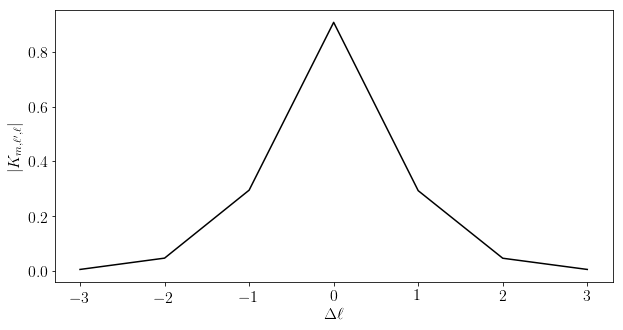

In [60]:
L = np.arange(-kernel.delta_ell,kernel.delta_ell+1)
plt.figure(figsize=(10,5))


plt.plot(L,np.abs(K_mlpL),'k')
plt.xlabel(r"$\Delta \ell$")
plt.ylabel(r"$|K_{m,\ell',\ell}|$")

plt.show()

# Simulate the sky

In [83]:
import healpy as hp 
import numpy as np

Dl = np.load("cosmoboost/CAMB_Cl_H0=67.74,ombh2=0.022,omch2=0.1188,mnu=0.06,tau=0.066,As=2.3e-9,ns=0.9667.npy")

T_0 = 2.725
L=np.arange(lmax+1)
rescale = T_0**2*(2*np.pi) / (L*(L+1)) #conversion factor from Dl to Cl
rescale[0]=0. #fix the ell=0 mode from inf to 0

Dl_TT=Dl[:lmax+1,0]
Dl_EE=Dl[:lmax+1,1]
Dl_BB=Dl[:lmax+1,2]
Dl_TE=Dl[:lmax+1,3]

Cl_TT = rescale*Dl_TT
Cl_EE = rescale*Dl_EE
Cl_BB = rescale*Dl_BB
Cl_TE = rescale*Dl_TE


Cl = np.array([Cl_TT,Cl_EE,Cl_BB,Cl_TE])
alm_T, alm_E, alm_B = hp.synalm(Cl,lmax=lmax,new=True,verbose=True)

alm_r = np.array([alm_T, alm_E, alm_B])

Cl_r = hp.alm2cl(alm_r)

In [ ]:
# plot the power spectra in the rest frame

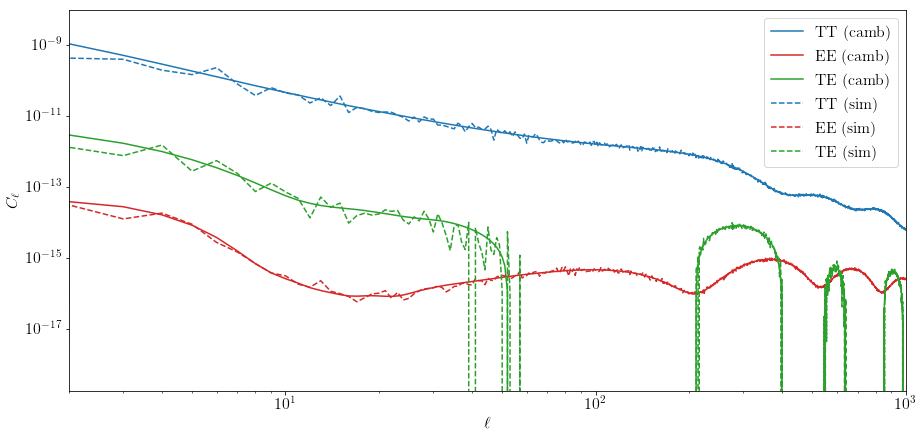

In [84]:
plt.figure(figsize=(15,7))
plt.plot(L,Cl_TT, label="TT (camb)",color='tab:blue')
plt.plot(L,Cl_EE, label="EE (camb)",color='tab:red')
plt.plot(L,Cl_TE, label="TE (camb)",color='tab:green')

plt.plot(L,Cl_r[0],label="TT (sim)",color='tab:blue',linestyle='--')
plt.plot(L,Cl_r[1],label="EE (sim)",color='tab:red',linestyle='--')
plt.plot(L,Cl_r[3],label="TE (sim)",color='tab:green',linestyle='--')
#plt.plot(L,Cl_sim[3])
#plt.plot(L,Cl_sim[4])
#plt.plot(L,Cl_sim[5])

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")

plt.xscale("log")
plt.yscale("log")

plt.legend(loc="upper right")
plt.xlim(2,lmax)
plt.show()

# Boost the Sky

In [98]:
# boost the alm
alm_T_r = alm_T
alm_T_b = cb.deboost_alm(alm_T_r,kernel)
#alm_T_boos_217 = cb.deboost_alm(alm_T[None,:],kernel,217)

adding new axis to alm...

deboosting almT



In [89]:
# calculate the tempreture power spectrum in the boosted frame
Cl_T_r = Cl_r[0]
Cl_T_b = hp.alm2cl(alm_T_b)


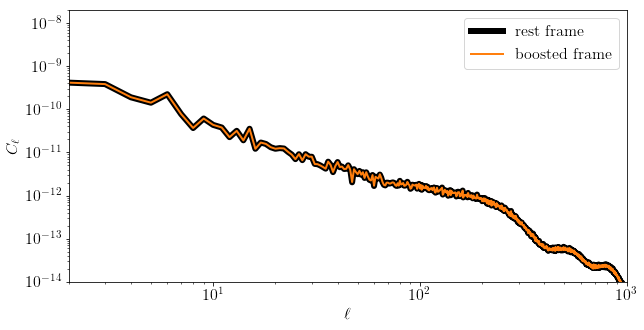

In [93]:
plt.figure(figsize=(10,5,))
plt.plot(L,Cl_T_r,linewidth=6,color='k',label='rest frame')
plt.plot(L,Cl_T_b,linewidth=2,color="tab:orange",label='boosted frame')

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")

plt.xscale("log")
plt.yscale("log")
plt.xlim(2,lmax)
plt.ylim(1E-14,2E-8)
plt.legend()

plt.show()

# Mask The sky

In [95]:
def tophalfcut_mask(cut_angle, lat_pix):
    mask = np.zeros(len(lat_pix))
    mask[(lat_pix < cut_angle)] = 1.

    f_sky = len(mask[mask == 0.]) / len(mask)

    return mask, f_sky

In [96]:
NSIDE=1024
NPIX = hp.nside2npix(NSIDE)
lon_pix, lat_pix = hp.pix2ang(NSIDE,np.arange(NPIX),lonlat=True)

In [101]:
mask_45,f_sky = tophalfcut_mask(45,lat_pix)

In [107]:
T_map_r = hp.alm2map(alm_T_r,NSIDE)
T_map_b = hp.alm2map(alm_T_b,NSIDE)

T_map_r_ma = hp.ma(T_map_r);
print(T_map_r_ma.shape)
T_map_r_ma.mask = mask_45

T_map_b_ma = hp.ma(T_map_b);
print(T_map_b_ma.shape)
T_map_b_ma.mask = mask_45

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(12582912,)
(12582912,)


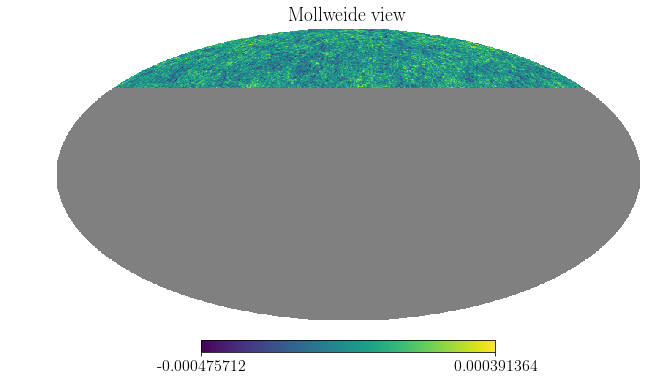

In [113]:
hp.mollview(T_map_r_ma)


In [118]:
Cl_T_r_ma =(1/f_sky)*hp.anafast(T_map_r_ma,lmax=lmax)

Cl_T_b_ma =(1/f_sky)*hp.anafast(T_map_b_ma,lmax=lmax)


In [139]:
dCl_over_Cl = (Cl_T_r_ma/Cl_T_b_ma)-1

from scipy.ndimage import gaussian_filter as GF
dCl_over_Cl_GF = GF(dCl_over_Cl,20)

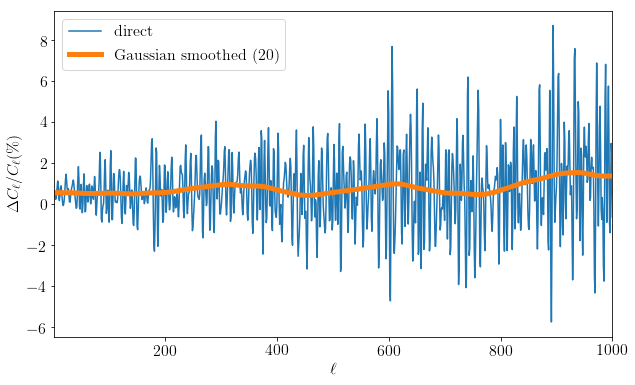

In [143]:
plt.figure(figsize=(10,6))
plt.plot(L,100*(dCl_over_Cl),label="direct")
plt.plot(L,100*(dCl_over_Cl_GF),linewidth=5,label="Gaussian smoothed (20)")

plt.xlabel("$\ell$")
plt.ylabel("$\Delta C_\ell/C_\ell (\%)$")

plt.legend()
plt.xlim(2,lmax)
plt.show()

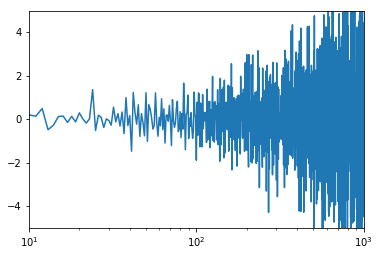

In [99]:


plt.plot(L, 100*(np.true_divide(Cl_b[0],Cl[0] )-1) )
#plt.plot(L,Cl[0])
#plt.plot(L,Cl[1])


#plt.ylim(1E-12,1E-8)
plt.xlim(10,1000)
plt.ylim(-5,5)
#plt.yscale("log")
plt.xscale("log")
plt.show()